In [29]:
import numpy as np
import os, random, pickle
import tqdm
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from itertools import permutations
from torch.utils.data import DataLoader, Dataset



In [30]:
!wget https://raw.githubusercontent.com/tikendraw/infinite-shakespeare/main/shakespeare.txt

--2023-06-27 01:21:22--  https://raw.githubusercontent.com/tikendraw/infinite-shakespeare/main/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt.2’

shakespeare.txt.2   100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-06-27 01:21:22 (59.4 MB/s) - ‘shakespeare.txt.2’ saved [1115394/1115394]



In [31]:
with open('shakespeare.txt', 'r') as f:
    text = f.readlines()

In [32]:
len(text), type(text)

(40000, list)

In [33]:
text =  ' '.join(text)

In [34]:
text[:44]

'First Citizen:\n Before we proceed any furthe'

In [35]:
chars = ''.join(sorted(set(text)))
chars

"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# Tokenization

We will create 2 character level token

In [36]:
a = permutations(chars,2)
a = list(a)

In [37]:
# permuation does not include chars like aa, bb 99 , doin that
for i in zip(chars, chars):
    a.append(''.join(i))

In [38]:
# joining tuples
a = [''.join(i) for i in a]  # 7140 combination possible

# keeping only tokens that exist in data
a = [i for i in a if i in text] # 2018 combination exists in data


In [39]:
stoi = {i:num for num, i in enumerate(a,1)} # token starts with 34
stoi["UNK"] = 0
itos = {i:num for num, i in stoi.items()}

In [40]:
def encode(x:str):
    if len(x.split())%2==1:
        x += ' '
    x = [x[i:i+2] for i in range(0, len(x), 2)]
    return [stoi[i] for i in x]

In [41]:
VOCAB_SIZE = len(stoi.values())
VOCAB_SIZE

1355

In [42]:
def replace_numbers_greater_than(numbers, limit:int, replace_with: int =0):
    return [num if 0 < num <= limit else replace_with for num in numbers]

In [43]:
RESERVED_TOKEN=0 # for unknown token

def decode(x):
    x = replace_numbers_greater_than(x, limit=VOCAB_SIZE-1, replace_with=RESERVED_TOKEN)
    return ''.join(itos[i] for i in x).strip()


In [44]:
encode('tikendr'), decode(encode('tikendr'))

([1189, 938, 1020, 1105], 'tikendr')

In [45]:
x = encode(text)

In [46]:
len(x)

577697

# Config

In [47]:
len(stoi)

1355

In [48]:
@dataclass
class GPTConfig:
    block_size: int = 500 # context_length
    vocab_size: int = len(stoi)  
    n_layer: int = 4
    n_head: int = 4
    n_embd: int = 64
    dropout: float = 0.05
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

config = GPTConfig()
config

GPTConfig(block_size=500, vocab_size=1355, n_layer=4, n_head=4, n_embd=64, dropout=0.05, bias=True, device='cuda')

# make DATA

In [49]:
test_size = int(len(x)*.99)
train, test = x[:test_size], x[test_size:]

print( 'train: ',len(train), ' + ' , 'test: ',len(test), ' = ',len(x))


train:  519927  +  test:  57770  =  577697


In [50]:
def create_dataset(numbers, window_size):
    n_windows = len(numbers) - window_size

    X = np.array([numbers[i:i+window_size] for i in range(n_windows)])
    y = np.array([numbers[i+1:i+window_size+1] for i in range(n_windows)]) # shifted by one value

    print("Number of windows:", len(X))
    print("Number of corresponding outputs:", len(y), end = '\n')

    return X, y


In [51]:
window_size = 10

xtr, ytr = create_dataset(train, config.block_size)
xts, yts = create_dataset(test, config.block_size)


Number of windows: 519427
Number of corresponding outputs: 519427
Number of windows: 57270
Number of corresponding outputs: 57270


In [52]:
xtr.shape, ytr.shape

((519427, 500), (519427, 500))

In [53]:
# xtr[0], ytr[0] 

# DataLoader

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [55]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        return self.x[idx],self.y[idx]



dataset = CustomDataset(xtr, ytr)
testdataset = CustomDataset(xts, yts)

batch_size = 32

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
testdataloader = DataLoader(testdataset, batch_size=batch_size)


for inputs, targets in dataloader:
    # inputs = batch['input']
    # targets = batch['target']
    print(inputs.shape, targets.shape)
    break


torch.Size([32, 500]) torch.Size([32, 500])


# Model

<img src='https://storrs.io/content/images/2021/08/Screen-Shot-2021-08-07-at-7.51.37-AM.png'>

# Scale Dot Product

In [56]:
q = torch.randn(1, config.block_size, 8)
k = torch.randn(1, config.block_size, 8)
v = torch.randn(1, config.block_size, 8)


In [57]:
mask = torch.tril(torch.ones(config.block_size,config.block_size))
mask, q.shape

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 torch.Size([1, 500, 8]))

In [58]:
def scale_dot_product(q,k,v, mask=None, return_attention = False, print_shape=False, show_attention=False):

    d_embed = q.shape[-1]

    a = (q @ k.transpose(-2,-1)) / d_embed**(1/2)

    if mask is not None:
        # for visual purpose
        if show_attention:
            visible_attention_score = a.masked_fill(mask == 0, 0)
            plt.imshow(visible_attention_score.squeeze())
        # real
        attention_score = a.masked_fill(mask == 0, -9e20)

    attention_score = F.softmax(a, dim=-1)

    values = attention_score @ v

    if print_shape:
        print('q: ',q.shape, '\nk: ', k.shape, '\nv: ', k.shape)
        print()

        print('values   : ',values.shape)
        print('attention: ',attention_score.shape)

    if return_attention:
        return values, attention_score
    else:
        return values

val, attention_score = scale_dot_product(q,k,v,mask=mask, return_attention = True ,print_shape=True, show_attention=False)

q:  torch.Size([1, 500, 8]) 
k:  torch.Size([1, 500, 8]) 
v:  torch.Size([1, 500, 8])

values   :  torch.Size([1, 500, 8])
attention:  torch.Size([1, 500, 500])


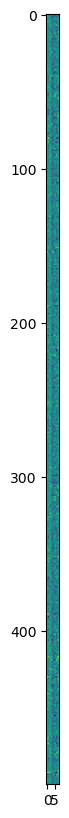

In [59]:
plt.figure(figsize=(20,10))
plt.imshow(val.squeeze())
plt.tight_layout()

In [60]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e20)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values

# Causal MultiheadAttention

<img src='https://coriva.eu.org/images/multiheadattention.png'>

In [61]:

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y


In [62]:
att = CausalSelfAttention(config)
inputs = torch.randn(1, config.block_size, config.n_embd)
print('input: ', inputs.shape)
y = att(inputs)
print('output: ', y.shape)

input:  torch.Size([1, 500, 64])
output:  torch.Size([1, 500, 64])


# LayerNorm

In [63]:
ndim = 4
weight = nn.Parameter(torch.ones(ndim))
weight

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

In [64]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [65]:
lay_norm = LayerNorm(config.n_embd, False)
l = lay_norm(y)
print(l.shape)

torch.Size([1, 500, 64])


(array([ 2.,  3.,  2.,  7.,  3., 18., 16.,  8.,  2.,  3.]),
 array([-2.80498219, -2.30343986, -1.80189753, -1.30035532, -0.79881299,
        -0.29727066,  0.20427164,  0.70581394,  1.20735621,  1.70889854,
         2.21044087]),
 <BarContainer object of 10 artists>)

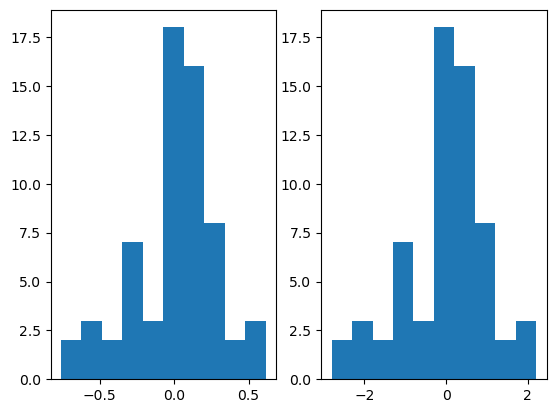

In [66]:
plt.subplot(1,2,1)
plt.hist(y[0][0].detach().numpy())
plt.subplot(1,2,2)
plt.hist(l[0][0].detach().numpy())

# MLP

In [67]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # x = self.c_fc(x)
        # x = self.gelu(x)
        # x = self.c_proj(x)
        # x = self.dropout(x)


        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

In [68]:
mlp = MLP(config)
mlp_y = mlp(l)
mlp_y.shape

torch.Size([1, 500, 64])

# Decoder Block

In [69]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        # new: normalization before attention, mlp
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [70]:
blk = Block(config)
blk_y = blk(inputs)
blk_y.shape

torch.Size([1, 500, 64])

# NanoGPT

In [71]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            # print('logits shape: ', logits.shape)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

    @torch.no_grad()
    def write(self, *args, **kwargs):
        out = self.generate(*args, **kwargs).tolist()
        return [decode(i) for i in out]


In [72]:
for i, j in dataloader:
    print(i.device)
    print(i.shape, j.shape)
    break

cpu
torch.Size([32, 500]) torch.Size([32, 500])


In [73]:
gpt = GPT(config).to(config.device)
out = gpt(i.to(config.device), j.to(config.device))

number of parameters: 0.29M


In [74]:
out[0].shape

torch.Size([32, 500, 1355])

In [75]:
ss = gpt.write(idx=i.to(config.device), max_new_tokens=100)
print(len(ss))
print(ss[:1])

32
["t\n Prefix'd for's parting: yet, good deed, Leontes,\n I love thee not a jar o' the clock behind\n What lady-she her lord. You'll stay?\n \n POLIXENES:\n No, madam.\n \n HERMIONE:\n Nay, but you will?\n \n POLIXENES:\n I may not, verily.\n \n HERMIONE:\n Verily!\n You put me off with limber vows; but I,\n Though you would seek to unsphere the\n stars with oaths,\n Should yet say 'Sir, no going.' Verily,\n You shall not go: a lady's 'Verily' 's\n As potent as a lord's. Will you go yet?\n Force me to keep you as a prisoner,\n Not like a guest; so you shall pay your fees\n When you depart, and save your thanks. How say you?\n My prisoner? or my guest? by your dread 'Verily,'\n One of them you shall be.\n \n POLIXENES:\n Your guest, then, madam:\n To be your prisoner should import offending;\n Which is for me less easy to commit\n Than you to punish.\n \n HERMIONE:\n Not your gaoler, then,\n But your kind hostess. Come, I'll question you\n Of my lord's tricks and yours when you were b

# Training


In [76]:
LEARNING_RATE = 1e-2

In [77]:
optimizer = torch.optim.AdamW(gpt.parameters(), lr = LEARNING_RATE)

In [78]:
from IPython.display import clear_output

In [148]:
def training_loop(model, data, optimizer, train_step:int=None, device=device):

    if train_step is None:
        train_step = len(data)

    model.train()

    losses = []

    for num, (x, y) in enumerate(data, 1):

        if (num == train_step+1) :
            break
        else:
            _ , loss = model(x.to(device),y.to(device))

            optimizer.zero_grad()

            loss.backward()
            losses.append(loss.item())
            optimizer.step()

    return np.mean(losses)

In [149]:
# import sys
# import time
# for i in range (1,11):
#     sys.stdout.write('\r' + str(i))
#     sys.stdout.flush()
#     time.sleep(1)

In [153]:
epochs = 100
for epoch in range(1, epochs+1):

    epoch_loss = training_loop(gpt.to(config.device), dataloader, optimizer=optimizer, train_step = 10, device=config.device)

    if epoch % epochs//11 ==0:
        print(f'Epoch:  {epoch:4}  |  Loss:  {epoch_loss:.5f}')
#         print()


Epoch:     1  |  Loss:  2.60139
Epoch:     2  |  Loss:  2.57300
Epoch:     3  |  Loss:  2.59338
Epoch:     4  |  Loss:  2.58036
Epoch:     5  |  Loss:  2.56382
Epoch:     6  |  Loss:  2.60314
Epoch:     7  |  Loss:  2.58008
Epoch:     8  |  Loss:  2.59350
Epoch:     9  |  Loss:  2.58966
Epoch:    10  |  Loss:  2.60647
Epoch:   100  |  Loss:  2.57134


# Cosine Similarity between real and pred

In [154]:
print(len(testdataloader))
for in_test , out_test in testdataloader:
    print(in_test.shape, out_test.shape)
    break

1790
torch.Size([32, 500]) torch.Size([32, 500])


In [177]:
out = gpt.generate(idx=in_test.to(config.device), max_new_tokens=500)
out.shape

torch.Size([32, 1000])

In [187]:
jss = []
for i in out_test.tolist():
    jss.append(decode(i))
    


In [189]:
ss = gpt.write(idx=in_test.to(config.device), max_new_tokens=500)
# ss

In [190]:

# import string
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# def cosine_similarity(x,y):  
#     ''' function to measure the similarity between two sentences using cosine similari'''
#     # tokenization
#     X_list = word_tokenize(x) 
#     Y_list = word_tokenize(y)

#     # sw contains the list of stopwords
#     sw = stopwords.words('english') 
#     l1 =[];l2 =[]

#     # remove stop words from the string
#     X_set = {w for w in X_list if not w in sw} 
#     Y_set = {w for w in Y_list if not w in sw}

#     # form a set containing keywords of both strings 
#     rvector = X_set.union(Y_set) 
#     for w in rvector:
#         if w in X_set: l1.append(1) # create a vector
#         else: l1.append(0)
#         if w in Y_set: l2.append(1)
#         else: l2.append(0)
#     c = 0

#     # cosine formula 
#     for i in range(len(rvector)):
#             c+= l1[i]*l2[i]
#     cosine = c / float((sum(l1)*sum(l2))**0.5)
#     return cosine



In [196]:
# all_sim = []
# for i, j in zip(ss, jss):
#     cos_sim = cosine_similarity(i, j)
#     all_sim.append(cos_sim)
#     print(cos_sim)

# print(f'Average similarity achieved for one batch:  {np.mean(all_sim)*100:.2f}% ')


# Generated output

In [166]:

!git clone https://github.com/tikendraw/funcyou.git -q

from funcyou.funcyou.utils import printt

In [195]:
printt('Original', 'Predicted', terminal_width = 150)
print()
idx = random.randint(0,32)
printt(jss[idx] + jss[idx+1], ss[idx],  terminal_width = 150)

Original                                                                   Predicted                                                                

nd mild behavior,                                                          and mild behavior,                                                       
 Am bold to show myself a forward guest                                     Am bold to show myself a forward guest                                  
 Within your house, to make mine eye the witness                            Within your house, to make mine eye the witness                         
 Of that report which I so oft have heard.                                  Of that report which I so oft have heard.                               
 And, for an entrance to my entertainment,                                  And, for an entrance to my entertainment,                               
 I do present you with a man of mine,                                       I do present you with a man o